In [2]:
import os.path
import cv2
import numpy as np
import pandas as pd

In [3]:
data_dir = "./datasets/"  # 데이터 디렉토리 경로
train = os.path.join(data_dir, 'train.csv')  # 훈련 데이터 디렉토리 경로
test = os.path.join(data_dir, 'test.csv')  # 테스트 데이터 디렉토리 경로
train_df = pd.read_csv(train)  # 훈련 데이터셋 데이터프레임 파일
test_df = pd.read_csv(test)  # 테스트 데이터셋 데이터프레임 파일
train_df = train_df.drop("Unnamed: 0", axis=1)

In [4]:
import torch
# GPU를 사용할 수 있는 경우, device를 'cuda'로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
device

device(type='cuda')

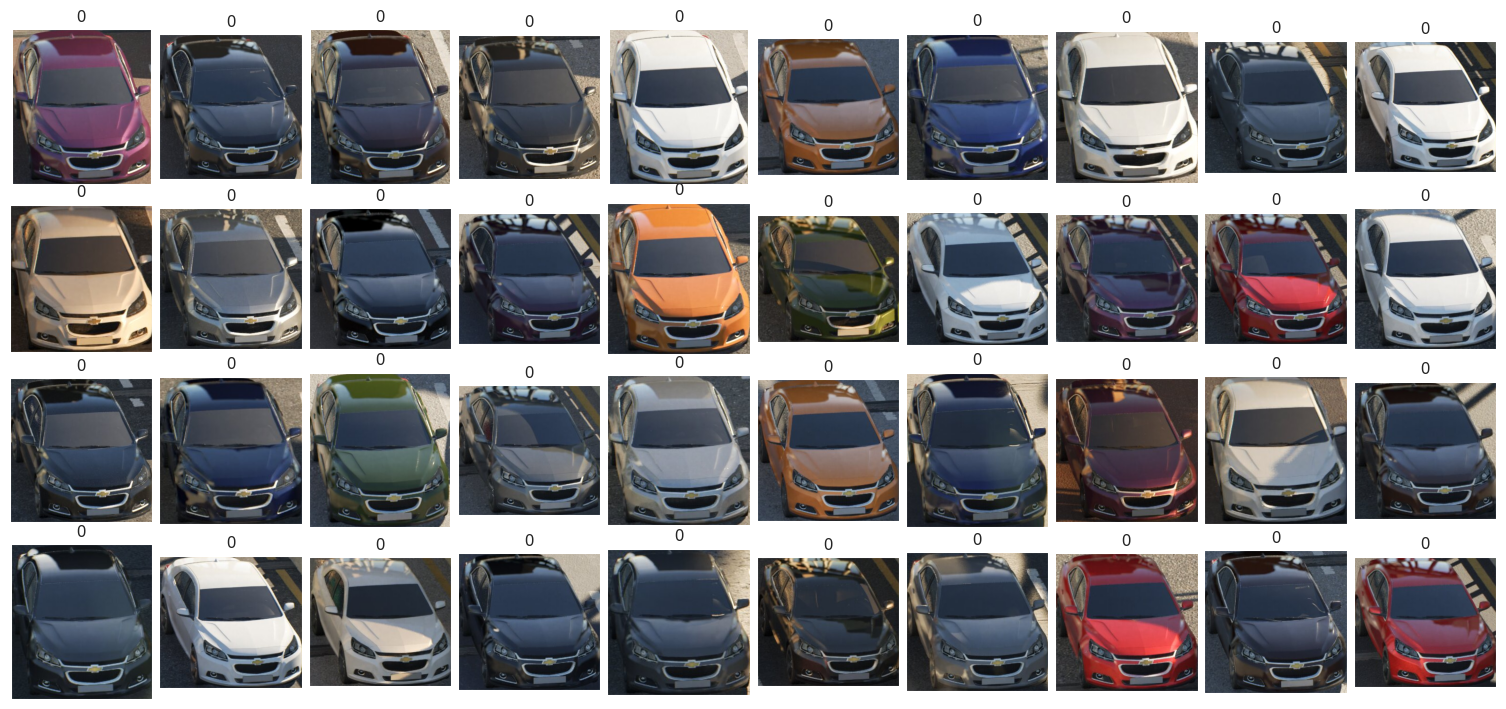

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.image[i]))
    ax.set_title(train_df.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

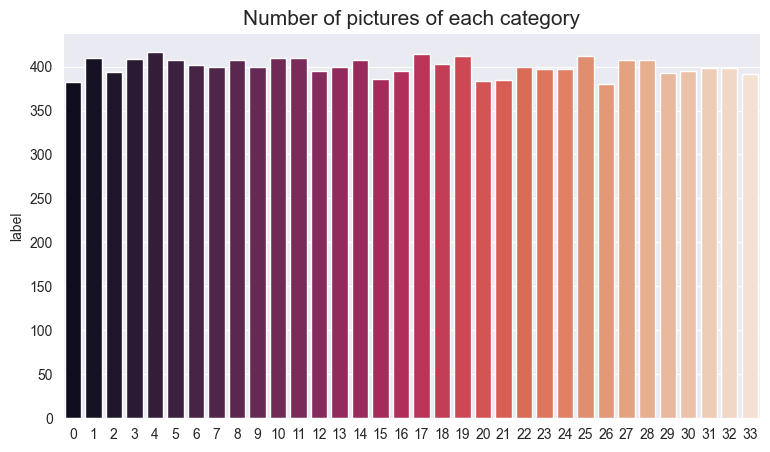

In [6]:
import seaborn as sns
vc = train_df['label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [43]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import torch
import os

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.img_labels = dataframe['label']
        self.img_paths = dataframe['image']
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths.iloc[idx]).convert("RGB")
        label = torch.tensor(int(self.img_labels.iloc[idx]))

        if self.transform:
            image = self.transform(image)

        return image, label


In [50]:
# train_df['label'].iloc[1]
train_df['image'].iloc[1]


TypeError: Unexpected type <class 'numpy.ndarray'>

In [44]:
from PIL import ImageOps
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])
dataset = CustomImageDataset(dataframe=train_df, transform=transform)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
validation_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - validation_size

print(train_size, validation_size, test_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

8164 2721 2722
Training Data Size : 8164
Validation Data Size : 2721
Testing Data Size : 2722


In [45]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
# ResNet50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.base_model = resnet50(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


In [46]:

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 학습 함수
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, num_epochs, patience):
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # 훈련 과정
        model.train()
        for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # 검증 과정
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} - Validation"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

        # 손실 계산
        train_loss = train_loss / len(train_dataloader.dataset)
        val_loss = val_loss / len(val_dataloader.dataset)

        # 얼리 스톱 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} as validation loss has not improved for {patience} epochs.")
                break

        # 학습률 스케줄링
        scheduler.step(val_loss)

        # 에폭별 결과 출력
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

num_classes=34
# 모델 초기화
model = ResNet50(num_classes)
model.to(device)

# 손실 함수, 옵티마이저, 스케줄러 초기화
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

# 학습 함수 호출
train(model, train_dataloader, validation_dataloader, criterion, optimizer, scheduler, device, num_epochs=10, patience=3)


C:\Users\Parkjunho\anaconda3\envs\gluon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Parkjunho\anaconda3\envs\gluon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 - Training:   0%|          | 0/510 [00:00<?, ?it/s]


TypeError: Unexpected type <class 'numpy.ndarray'>

In [17]:
test_df = test_df.drop("Unnamed: 0", axis=1)

In [36]:
import os
import torch
from torchvision import transforms
from PIL import Image
import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 변환 및 전처리 설정
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])
test_data_path = glob.glob("./datasets/test/11/*")
# 예측 함수
# 예측 함수
def predict_image(model, image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)  # 입력 데이터를 GPU로 이동
    with torch.no_grad():
        output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드 및 CUDA로 이동
model.to(device)
model.eval()
b = []
# test_data_path 내의 파일들에 대해 예측 수행
for file_path in test_data_path:
    prediction = predict_image(model, file_path)
    print(f"Prediction: {prediction}")
    b.append(prediction)

Prediction: 7
Prediction: 16
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 32
Prediction: 16
Prediction: 33
Prediction: 33
Prediction: 33
Prediction: 1
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 5
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 25
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 6
Prediction: 11
Prediction: 33
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 27
Prediction: 11
Prediction: 7
Prediction: 33
Prediction: 33
Prediction: 11
Prediction: 33


In [38]:
import torch
from torchvision import transforms
from PIL import Image
import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 변환 및 전처리 설정
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])
test_data_path = glob.glob("./datasets/test/11/*")
# 예측 함수
def predict_image(model, image_path):
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0)
    image = image.to(device)  # 입력 데이터를 GPU로 이동
    with torch.no_grad():
        output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()


# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드 및 CUDA로 이동
model.to(device)
model.eval()
a = []
# test_data_path 내의 파일들에 대해 예측 수행
for file_path in test_data_path:
    prediction = predict_image(model, file_path)
    print(f"Prediction: {prediction}")
    a.append(prediction)


Prediction: 7
Prediction: 0
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 32
Prediction: 28
Prediction: 33
Prediction: 33
Prediction: 33
Prediction: 0
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 11
Prediction: 33
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 5
Prediction: 11
Prediction: 11
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 25
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 16
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 6
Prediction: 11
Prediction: 33
Prediction: 33
Prediction: 11
Prediction: 11
Prediction: 33
Prediction: 11
Prediction: 27
Prediction: 11
Prediction: 7
Prediction: 33
Prediction: 33
Prediction: 11
Prediction: 33
P

In [40]:
for i in range(len(a)):
    if a[i] != b[i]:
        print(a[i])

0
28
0
33
33
16
16
27
16
27
27
27
24
3
33
24
7
24
